# Part 1: A/B Testing using Ad Click Prediction


1. Load the dataset into a pandas DataFrame.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats


In [2]:

# 1. Load the dataset
print("Loading dataset...")
df = pd.read_csv('ad_click_dataset.csv')
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")


Loading dataset...
Dataset loaded with 10000 rows and 9 columns.


2. Perform necessary data cleaning and preprocessing: 

a. Handle missing values

In [5]:
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64


In [6]:

# Handle missing values (fill or drop depending on extent)
if df.isnull().sum().sum() > 0:
    # Fill categorical columns with mode
    for col in ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Fill numerical columns with median
    for col in ['age']:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
            
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())



Missing values after cleaning:
id                  0
full_name           0
age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64


In [7]:

# Ensure ad_position is properly formatted for our A/B test
# Map 'Top' to 0 and 'Bottom' to 1
if df['ad_position'].dtype == 'object':
    # Check the unique values
    print("Unique values in ad_position:", df['ad_position'].unique())
    
    # Create mapping based on the values
    position_mapping = {'Top': 0, 'Side': 2, 'Bottom': 1}
    df['ad_position_numeric'] = df['ad_position'].map(position_mapping)
else:
    df['ad_position_numeric'] = df['ad_position']


Unique values in ad_position: ['Top' 'Side' 'Bottom']


In [8]:
df.shape

(10000, 10)

b. Convert categorical columns  (e.g., gender, ad_position)

In [9]:

# One-hot encode other categorical variables if needed for future modeling
categorical_cols = ['gender', 'device_type', 'browsing_history', 'time_of_day']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"After preprocessing, dataset has {df_encoded.shape[1]} columns")
    

After preprocessing, dataset has 17 columns


In [11]:
df_encoded.head()

,id,full_name,age,ad_position,click,ad_position_numeric,gender_Male,gender_Non-Binary,device_type_Mobile,device_type_Tablet,browsing_history_Entertainment,browsing_history_News,browsing_history_Shopping,browsing_history_Social Media,time_of_day_Evening,time_of_day_Morning,time_of_day_Night
0,670,User670,22.0,Top,1,0,False,False,False,False,False,False,True,False,False,False,False
1,3044,User3044,39.5,Top,1,0,True,False,False,False,True,False,False,False,False,True,False
2,5912,User5912,41.0,Side,1,2,False,True,False,False,False,False,False,False,False,False,True
3,5418,User5418,34.0,Bottom,1,1,True,False,False,False,True,False,False,False,True,False,False
4,9452,User9452,39.0,Bottom,0,1,False,True,False,False,False,False,False,True,False,True,False


1.Split the dataset into two groups: [10 points]

  a. Group A: Users with ad_position = 0 (Top)
  
  b. Group B: Users with ad_position = 1  (Bottom)


In [12]:

# Filter for Top and Bottom positions only (excluding Side if present)
ab_test_df = df[df['ad_position'].isin(['Top', 'Bottom'])]

group_a = ab_test_df[ab_test_df['ad_position'] == 'Top']
group_b = ab_test_df[ab_test_df['ad_position'] == 'Bottom']

print(f"Group A (Top position) size: {len(group_a)}")
print(f"Group B (Bottom position) size: {len(group_b)}")


Group A (Top position) size: 2597
Group B (Bottom position) size: 4817


4. Use the scipy’s stats.proportions_ztest function to perform an independent two-sample z-test between Group A and Group B.

In [13]:

# Calculate success counts (clicks) for each group
success_a = group_a['click'].sum()
success_b = group_b['click'].sum()

# Total observations in each group
nobs_a = len(group_a)
nobs_b = len(group_b)

# Print the click-through rates
ctr_a = success_a / nobs_a * 100
ctr_b = success_b / nobs_b * 100
print(f"Click-through rate for Group A (Top): {ctr_a:.2f}%")
print(f"Click-through rate for Group B (Bottom): {ctr_b:.2f}%")


Click-through rate for Group A (Top): 63.50%
Click-through rate for Group B (Bottom): 66.81%


5. Print the following:

The z-score [10 points]

The p-value [10 points]


In [15]:
from statsmodels.stats.proportion import proportions_ztest

# Perform z-test
count = np.array([success_a, success_b])
nobs = np.array([nobs_a, nobs_b])

z_stat, p_val = proportions_ztest(count, nobs)

print(f"\nZ-score: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")


Z-score: -2.8620
P-value: 0.0042


Interpret the result: Is there a statistically significant difference in click-through rates between the two groups? Justify your answer. [10 points]



In [16]:

# 5. Interpret the results
print("\nInterpretation:")
alpha = 0.05
if p_val < alpha:
    print(f"The p-value ({p_val:.4f}) is less than the significance level ({alpha}).")
    print("Therefore, we reject the null hypothesis.")
    print("CONCLUSION: There is a statistically significant difference in click-through rates between ads positioned")
    print("at the top versus the bottom of the webpage.")
    
    if ctr_a > ctr_b:
        print(f"Top positioned ads have a {ctr_a - ctr_b:.2f}% higher click-through rate than bottom positioned ads.")
    else:
        print(f"Bottom positioned ads have a {ctr_b - ctr_a:.2f}% higher click-through rate than top positioned ads.")
else:
    print(f"The p-value ({p_val:.4f}) is greater than the significance level ({alpha}).")
    print("Therefore, we fail to reject the null hypothesis.")
    print("CONCLUSION: There is no statistically significant difference in click-through rates between ads positioned")
    print("at the top versus the bottom of the webpage.")


Interpretation:
The p-value (0.0042) is less than the significance level (0.05).
Therefore, we reject the null hypothesis.
CONCLUSION: There is a statistically significant difference in click-through rates between ads positioned
at the top versus the bottom of the webpage.
Bottom positioned ads have a 3.31% higher click-through rate than top positioned ads.


2: Covariate Shift Detection Using Air Quality Data

Load all three datasets using pandas

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
train_df = pd.read_csv('train.csv')
test1_df = pd.read_csv('test1.csv')
test2_df = pd.read_csv('test2.csv')

print(f"Train dataset shape: {train_df.shape}")
print(f"Test1 dataset shape: {test1_df.shape}")
print(f"Test2 dataset shape: {test2_df.shape}")


Train dataset shape: (3200, 18)
Test1 dataset shape: (800, 18)
Test2 dataset shape: (800, 18)


In [19]:
train_df.head()

,Unnamed: 0,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,1849,26/05/2004,19.00.00,-200,1130.0,-200.0,"22,7",1368.0,-200.0,933.0,-200.0,1709.0,1269.0,"26,7","19,5","0,6754",NaN,NaN
1,2533,24/06/2004,07.00.00,"1,2",1030.0,-200.0,"6,9",851.0,102.0,824.0,68.0,1700.0,983.0,"21,9","57,0","1,4742",NaN,NaN
2,3047,15/07/2004,17.00.00,"3,2",1164.0,-200.0,"20,3",1306.0,259.0,648.0,198.0,1886.0,1218.0,"35,5","19,1","1,0888",NaN,NaN
3,805,13/04/2004,07.00.00,"3,9",1496.0,524.0,"19,1",1272.0,328.0,667.0,130.0,2011.0,1399.0,"11,0","64,2","0,8398",NaN,NaN
4,2962,12/07/2004,04.00.00,-200,780.0,-200.0,"1,8",568.0,24.0,1200.0,34.0,1331.0,501.0,"19,9","51,3","1,1803",NaN,NaN


For each test dataset (test1.csv and test2.csv), compare it with train.csv using the Kolmogorov–Smirnov test (scipy.stats.ks_2samp).
Perform the KS test on the NO2(GT) column to identify whether there are any distributional differences.

In [20]:

# Test 1 vs Train
ks_stat_test1, p_value_test1 = stats.ks_2samp(train_df['NO2(GT)'].dropna(), 
                                              test1_df['NO2(GT)'].dropna())

# Test 2 vs Train
ks_stat_test2, p_value_test2 = stats.ks_2samp(train_df['NO2(GT)'].dropna(), 
                                              test2_df['NO2(GT)'].dropna())

print(f"\nKS Test Results for NO2(GT):")
print(f"Test1 vs Train: KS statistic = {ks_stat_test1:.4f}, p-value = {p_value_test1:.4f}")
print(f"Test2 vs Train: KS statistic = {ks_stat_test2:.4f}, p-value = {p_value_test2:.4f}")



KS Test Results for NO2(GT):
Test1 vs Train: KS statistic = 0.0191, p-value = 0.9722
Test2 vs Train: KS statistic = 0.4075, p-value = 0.0000


Report the KS statistic and p-value for each feature.

In [22]:
# Define a function to perform KS test for a specific column
def perform_ks_test(col_name):
    if col_name in ['Unnamed: 15', 'Unnamed: 16']:
        return None, None, None, None
    
    try:
        # Test1 vs Train
        ks_stat_1, p_val_1 = stats.ks_2samp(train_df[col_name].dropna(), 
                                           test1_df[col_name].dropna())
        
        # Test2 vs Train
        ks_stat_2, p_val_2 = stats.ks_2samp(train_df[col_name].dropna(), 
                                           test2_df[col_name].dropna())
        
        return ks_stat_1, p_val_1, ks_stat_2, p_val_2
    except:
        return None, None, None, None


In [23]:

# Create empty lists to store results
columns = []
ks_test1 = []
p_test1 = []
ks_test2 = []
p_test2 = []

In [24]:

# Calculate KS test for each numerical column
for column in train_df.columns:
    if column not in ['Date', 'Time']:
        ks_stat_1, p_val_1, ks_stat_2, p_val_2 = perform_ks_test(column)
        
        if ks_stat_1 is not None:
            columns.append(column)
            ks_test1.append(ks_stat_1)
            p_test1.append(p_val_1)
            ks_test2.append(ks_stat_2)
            p_test2.append(p_val_2)


In [25]:

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Feature': columns,
    'KS_Stat_Test1': ks_test1,
    'p_value_Test1': p_test1,
    'KS_Stat_Test2': ks_test2,
    'p_value_Test2': p_test2
})

print(results_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

      Feature  KS_Stat_Test1  p_value_Test1  KS_Stat_Test2  p_value_Test2
   Unnamed: 0         0.0462         0.1270         1.0000         0.0000
       CO(GT)         0.0256         0.7888         0.2128         0.0000
  PT08.S1(CO)         0.0328         0.4900         0.1275         0.0000
     NMHC(GT)         0.0128         0.9999         0.2272         0.0000
     C6H6(GT)         0.0353         0.3966         0.0556         0.0372
PT08.S2(NMHC)         0.0216         0.9235         0.1419         0.0000
      NOx(GT)         0.0175         0.9885         0.5241         0.0000
 PT08.S3(NOx)         0.0344         0.4304         0.3228         0.0000
      NO2(GT)         0.0191         0.9722         0.4075         0.0000
 PT08.S4(NO2)         0.0200         0.9574         0.5972         0.0000
  PT08.S5(O3)         0.0281         0.6856         0.1366         0.0000
            T         0.0184         0.9799         0.2537         0.0000
           RH         0.0163         0

Determine which of the two test datasets (test1.csv or test2.csv) exhibits a covariate shift relative to the training dataset (train.csv). Use the results of the Kolmogorov–Smirnov test to support your answer.

In [26]:

# Count significant differences (p < 0.05) for each test dataset
sig_diff_test1 = sum(results_df['p_value_Test1'] < 0.05)
sig_diff_test2 = sum(results_df['p_value_Test2'] < 0.05)

print(f"Number of features with significant distributional differences (p < 0.05):")
print(f"Test1 vs Train: {sig_diff_test1} out of {len(columns)}")
print(f"Test2 vs Train: {sig_diff_test2} out of {len(columns)}")

# Calculate average KS statistic for each test dataset
avg_ks_test1 = np.mean(results_df['KS_Stat_Test1'])
avg_ks_test2 = np.mean(results_df['KS_Stat_Test2'])

print(f"\nAverage KS statistic:")
print(f"Test1 vs Train: {avg_ks_test1:.4f}")
print(f"Test2 vs Train: {avg_ks_test2:.4f}")

Number of features with significant distributional differences (p < 0.05):
Test1 vs Train: 0 out of 14
Test2 vs Train: 14 out of 14

Average KS statistic:
Test1 vs Train: 0.0253
Test2 vs Train: 0.3277


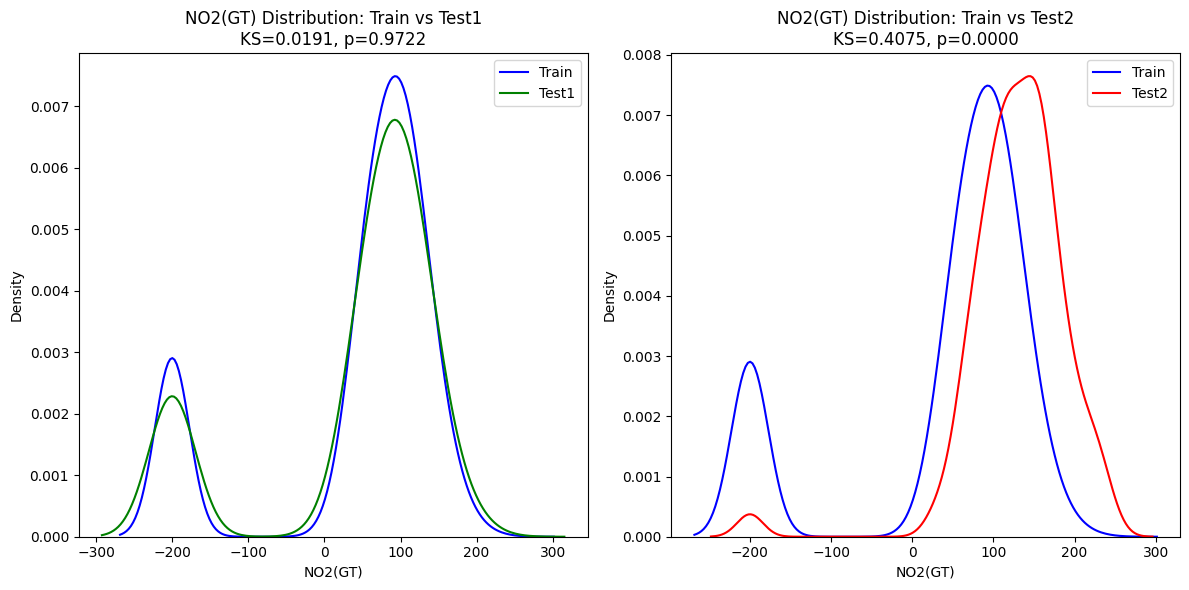

In [27]:

# Visualize distribution differences for NO2(GT)
plt.figure(figsize=(12, 6))

# NO2(GT) distributions
plt.subplot(1, 2, 1)
sns.kdeplot(train_df['NO2(GT)'].dropna(), label='Train', color='blue')
sns.kdeplot(test1_df['NO2(GT)'].dropna(), label='Test1', color='green')
plt.title(f'NO2(GT) Distribution: Train vs Test1\nKS={ks_stat_test1:.4f}, p={p_value_test1:.4f}')
plt.xlabel('NO2(GT)')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(train_df['NO2(GT)'].dropna(), label='Train', color='blue')
sns.kdeplot(test2_df['NO2(GT)'].dropna(), label='Test2', color='red')
plt.title(f'NO2(GT) Distribution: Train vs Test2\nKS={ks_stat_test2:.4f}, p={p_value_test2:.4f}')
plt.xlabel('NO2(GT)')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:

# Conclusion
print("\nConclusion:")
if avg_ks_test1 > avg_ks_test2 and sig_diff_test1 > sig_diff_test2:
    print("Test1 exhibits stronger covariate shift relative to the training dataset.")
elif avg_ks_test2 > avg_ks_test1 and sig_diff_test2 > sig_diff_test1:
    print("Test2 exhibits stronger covariate shift relative to the training dataset.")
else:
    # If the results are mixed, look at NO2(GT) specifically as mentioned in the task
    if ks_stat_test1 > ks_stat_test2 and p_value_test1 < p_value_test2:
        print("Based on the NO2(GT) column, Test1 exhibits stronger covariate shift relative to the training dataset.")
    elif ks_stat_test2 > ks_stat_test1 and p_value_test2 < p_value_test1:
        print("Based on the NO2(GT) column, Test2 exhibits stronger covariate shift relative to the training dataset.")
    else:
        print("Results are mixed across features. Further analysis is recommended.")


Conclusion:
Test2 exhibits stronger covariate shift relative to the training dataset.
